# Dynamical X-ray Scattering with dynamic Debye-Waller factor

In this example static and transient X-ray simulations are carried out employing the dynamical X-ray scattering formalism.

## Setup

Do all necessary imports and settings.

In [1]:
import udkm1Dsim as ud
u = ud.u  # import the pint unit registry from udkm1Dsim
import scipy.constants as constants
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
u.setup_matplotlib()  # use matplotlib with pint units

## Structure

Refer to the [structure-example](structure.ipynb) for more details.

In [2]:
O = ud.Atom('O')
Ti = ud.Atom('Ti')
Sr = ud.Atom('Sr')
Ru = ud.Atom('Ru')
Pb = ud.Atom('Pb')
Zr = ud.Atom('Zr')

In [3]:
# c-axis lattice constants of the two layers
c_STO_sub = 3.905*u.angstrom
c_SRO = 3.94897*u.angstrom
# sound velocities [nm/ps] of the two layers
sv_SRO = 6.312*u.nm/u.ps
sv_STO = 7.800*u.nm/u.ps

# SRO layer
prop_SRO = {}
prop_SRO['a_axis'] = c_STO_sub  # aAxis
prop_SRO['b_axis'] = c_STO_sub  # bAxis
prop_SRO['deb_wal_fac'] = '2*T'  # Debye-Waller factor
prop_SRO['sound_vel'] = sv_SRO  # sound velocity
prop_SRO['opt_ref_index'] = 2.44+4.32j
prop_SRO['therm_cond'] = 5.72*u.W/(u.m*u.K)  # heat conductivity
prop_SRO['lin_therm_exp'] = 1.03e-5  # linear thermal expansion
prop_SRO['heat_capacity'] = '455.2 + 0.112*T - 2.1935e6/T**2'  # [J/kg K]

SRO = ud.UnitCell('SRO', 'Strontium Ruthenate', c_SRO, **prop_SRO)
SRO.add_atom(O, 0)
SRO.add_atom(Sr, 0)
SRO.add_atom(O, 0.5)
SRO.add_atom(O, 0.5)
SRO.add_atom(Ru, 0.5)

# STO substrate
prop_STO_sub = {}
prop_STO_sub['a_axis'] = c_STO_sub  # aAxis
prop_STO_sub['b_axis'] = c_STO_sub  # bAxis
prop_STO_sub['deb_wal_fac'] = '1*T'  # Debye-Waller factor
prop_STO_sub['sound_vel'] = sv_STO  # sound velocity
prop_STO_sub['opt_ref_index'] = 2.1+0j
prop_STO_sub['therm_cond'] = 12*u.W/(u.m*u.K)  # heat conductivity
prop_STO_sub['lin_therm_exp'] = 1e-5  # linear thermal expansion
prop_STO_sub['heat_capacity'] = '733.73 + 0.0248*T - 6.531e6/T**2'  # [J/kg K]

STO_sub = ud.UnitCell('STOsub', 'Strontium Titanate Substrate',
                      c_STO_sub, **prop_STO_sub)
STO_sub.add_atom(O, 0)
STO_sub.add_atom(Sr, 0)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(O, 0.5)
STO_sub.add_atom(Ti, 0.5)

In [4]:
S = ud.Structure('Single Layer')
S.add_sub_structure(SRO, 200)  # add 100 layers of SRO to sample
S.add_sub_structure(STO_sub, 1000)  # add 1000 layers of dynamic STO substrate

substrate = ud.Structure('Static Substrate')
# add 1000000 layers of static STO substrate
substrate.add_sub_structure(STO_sub, 1000000)
S.add_substrate(substrate)

In [5]:
SRO.deb_wal_fac[0](300)

600

## Heat

Refer to the [heat-example](heat.ipynb) for more details.

In [6]:
h = ud.Heat(S, True)

h.save_data = False
h.disp_messages = True

h.excitation = {'fluence': [35]*u.mJ/u.cm**2,
                'delay_pump':  [0]*u.ps,
                'pulse_width':  [0]*u.ps,
                'multilayer_absorption': True,
                'wavelength': 800*u.nm,
                'theta': 45*u.deg}

# temporal and spatial grid
delays = np.r_[-5:40:0.1]*u.ps
_, _, distances = S.get_distances_of_layers()

In [7]:
temp_map, delta_temp_map = h.get_temp_map(delays, 300*u.K)

Surface incidence fluence scaled by factor 0.7071 due to incidence angle theta=45.00 deg
Absorption profile is calculated by multilayer formalism.
Total reflectivity of 58.5 % and transmission of 0.4 %.
Elapsed time for _temperature_after_delta_excitation_: 0.408636 s
Elapsed time for _temp_map_: 0.438587 s


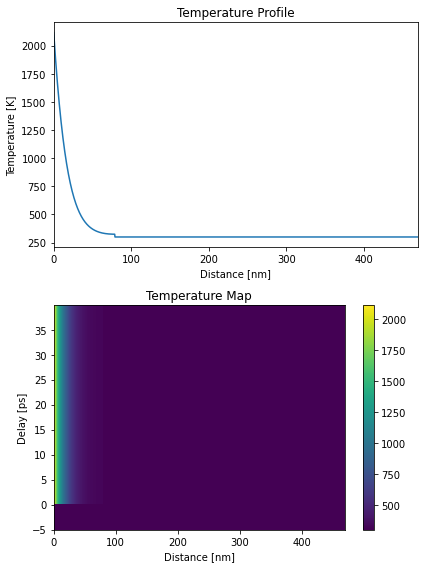

In [8]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, temp_map[101, :])
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Temperature [K]')
plt.title('Temperature Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude, temp_map, shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Temperature Map')

plt.tight_layout()
plt.show()

## Numerical Phonons

Refer to the [phonons-example](phonons.ipynb) for more details.

In [9]:
p = ud.PhononNum(S, True)
p.save_data = False
p.disp_messages = True

In [10]:
strain_map = p.get_strain_map(delays, temp_map, delta_temp_map)

Calculating linear thermal expansion ...
Calculating coherent dynamics with ODE solver ...


0it [00:00, ?it/s]

Elapsed time for _strain_map_: 1.015786 s


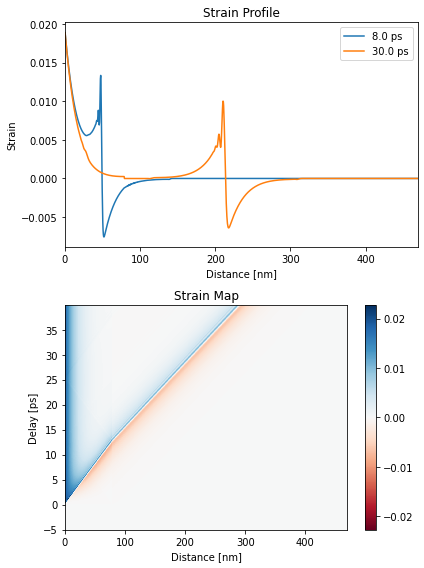

In [11]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.plot(distances.to('nm').magnitude, strain_map[130, :], label=np.round(delays[130]))
plt.plot(distances.to('nm').magnitude, strain_map[350, :], label=np.round(delays[350]))
plt.xlim([0, distances.to('nm').magnitude[-1]])
plt.xlabel('Distance [nm]')
plt.ylabel('Strain')
plt.legend()
plt.title('Strain Profile')

plt.subplot(2, 1, 2)
plt.pcolormesh(distances.to('nm').magnitude, delays.to('ps').magnitude,
               strain_map, cmap='RdBu', vmin=-np.max(strain_map),
               vmax=np.max(strain_map), shading='auto')
plt.colorbar()
plt.xlabel('Distance [nm]')
plt.ylabel('Delay [ps]')
plt.title('Strain Map')

plt.tight_layout()
plt.show()

## Initialize dynamical X-ray simulation

The `XrayDyn` class requires a `Structure` object and a boolean `force_recalc` in order overwrite previous simulation results.

These results are saved in the `cache_dir` when `save_data` is enabled.
Printing simulation messages can be en-/disabled using `disp_messages` and progress bars can using the boolean switch `progress_bar`.

In [12]:
dyn = ud.XrayDynDebyeWaller(S, True)
dyn.disp_messages = True
dyn.save_data = False

incoming polarizations set to: sigma
analyzer polarizations set to: unpolarized


## Homogeneous X-ray scattering

For the case of homogeneously strained samples, the dynamical X-ray scattering simulations can be greatly simplified, which saves a lot of computational time.

### $q_z$-scan

The `XrayDyn` object requires an `energy` and scattering vector `qz` to run the simulations.  
Both parameters can be arrays and the resulting reflectivity has a first dimension for the photon energy and the a second for the scattering vector.

In [13]:
dyn.energy = np.r_[5000, 8047]*u.eV  # set two photon energies
dyn.qz = np.r_[3.1:3.3:0.00001]/u.angstrom  # qz range

R_hom, A = dyn.homogeneous_reflectivity()  # this is the actual calculation

Calculating _homogenous_reflectivity_ ...
Elapsed time for _homogenous_reflectivity_: 3.333784 s


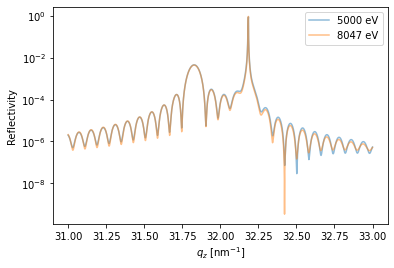

In [14]:
plt.figure()
plt.semilogy(dyn.qz[0, :], R_hom[0, :], label='{}'.format(dyn.energy[0]), alpha=0.5)
plt.semilogy(dyn.qz[1, :], R_hom[1, :], label='{}'.format(dyn.energy[1]), alpha=0.5)
plt.ylabel('Reflectivity')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.legend()
plt.show()

Due to the very thick static `substrate` in the `structure` and the very small step width in `qz` also the Darwin width of the substrate Bragg peak is nicely resolvable. 

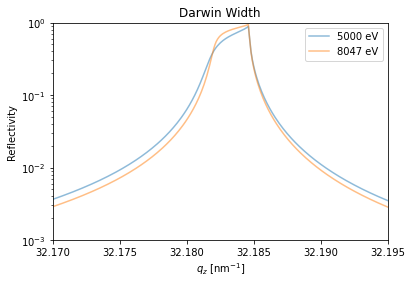

In [15]:
plt.figure()
plt.semilogy(dyn.qz[0, :], R_hom[0, :], label='{}'.format(dyn.energy[0]), alpha=0.5)
plt.semilogy(dyn.qz[1, :], R_hom[1, :], label='{}'.format(dyn.energy[1]), alpha=0.5)
plt.ylabel('Reflectivity')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.xlim(32.17, 32.195)
plt.ylim(1e-3, 1)
plt.legend()
plt.title('Darwin Width')
plt.show()

### Post-Processing

All result can be convoluted with an arbitrary function handle, which e.g. mimics the instrumental resolution.

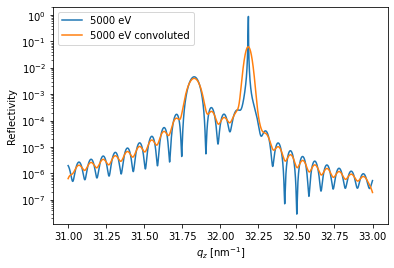

In [16]:
FWHM = 0.004/1e-10  # Angstrom
sigma = FWHM/2.3548

handle = lambda x: np.exp(-((x)/sigma)**2/2)
y_conv = dyn.conv_with_function(R_hom[0, :], dyn._qz[0, :], handle)

plt.figure()
plt.semilogy(dyn.qz[0, :], R_hom[0, :], label='{}'.format(dyn.energy[0]))
plt.semilogy(dyn.qz[0, :], y_conv, label='{} convoluted'.format(dyn.energy[0]))
plt.ylabel('Reflectivity')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.legend()
plt.show()

### Energy-scan

Energy scans rely on experimental atomic scattering factors that are include also energy ranges around relevant resonances.  
The warning message can be safely ignored as it results from the former `q_z` range which cannot be accessed with the new energy range.

c:\users\loc_schick\general\git\udkm1dsim\udkm1Dsim\simulations\xrays.py:239: RuntimeWarning: invalid value encountered in arcsin
  self._theta = np.arcsin(np.outer(self._wl, self._qz[0, :])/np.pi/4)


Calculating _homogenous_reflectivity_ ...
Elapsed time for _homogenous_reflectivity_: 0.789816 s


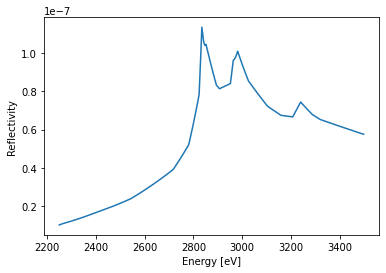

In [17]:
dyn.energy = np.r_[2250:3500]*u.eV  # set the energy range
dyn.qz = np.r_[2]/u.angstrom  # qz range

R_hom, A = dyn.homogeneous_reflectivity()  # this is the actual calculation

plt.figure()
plt.plot(dyn.energy, R_hom[:, 0])
plt.ylabel('Reflectivity')
plt.xlabel('Energy [eV]')
plt.show()

## Inhomogeneous X-ray scattering

The `inhomogeneous_reflectivity()` method allows to calculate the transient X-ray reflectivity according to a `strain_map`.

The actual strains per layer will be discretized and limited in order to save computational time using the `strain_vectors`.

In [ ]:
dyn.energy = np.r_[8047]*u.eV  # set two photon energies
dyn.qz = np.r_[3.1:3.3:0.001]/u.angstrom  # qz range

R_seq = dyn.inhomogeneous_reflectivity(strain_map, temp_map, calc_type='sequential')

Calculating _inhomogeneousReflectivity_ ...


Progress:   0%|          | 0/450 [00:00<?, ?it/s]

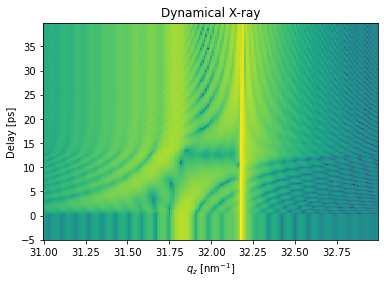

In [18]:
plt.figure()
plt.pcolormesh(dyn.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude, np.log10(R_seq[:, 0, :]),
               shading='auto')
plt.title('Dynamical X-ray')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.show()

The results can be convoluted again to mimic real experimental resolution:

In [19]:
R_seq_conv = np.zeros_like(R_seq)
for i, delay in enumerate(delays):
    R_seq_conv[i, 0, :] = dyn.conv_with_function(R_seq[i, 0, :], dyn._qz[0, :], handle)

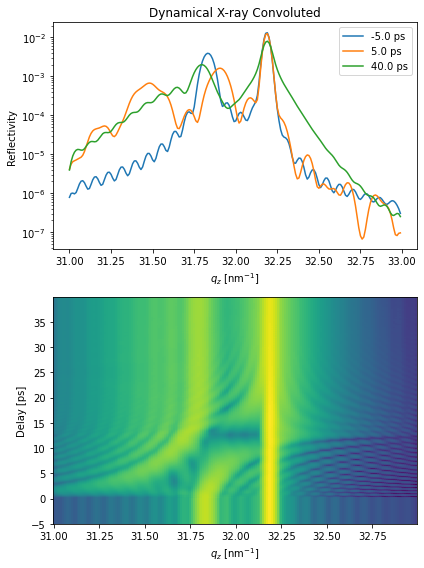

In [20]:
plt.figure(figsize=[6, 8])
plt.subplot(2, 1, 1)
plt.semilogy(dyn.qz[0, :].to('1/nm'), R_seq_conv[0, 0, :], label=np.round(delays[0]))
plt.semilogy(dyn.qz[0, :].to('1/nm'), R_seq_conv[100, 0, :], label=np.round(delays[100]))
plt.semilogy(dyn.qz[0, :].to('1/nm'), R_seq_conv[-1, 0, :], label=np.round(delays[-1]))

plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.ylabel('Reflectivity')
plt.legend()
plt.title('Dynamical X-ray Convoluted')

plt.subplot(2, 1, 2)
plt.pcolormesh(dyn.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude,
               np.log10(R_seq_conv[:, 0, :]), shading='auto')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')

plt.tight_layout()
plt.show()

## Parallel inhomogeneous X-ray scattering

You need to install the `udkm1Dsim` with the `parallel` option which essentially add the Dask package to the requirements:

```
> pip install udkm1Dsim[parallel]
```

You can also install/add Dask manually, e.g. via pip:

```
> pip install dask
```

Please refer to the [Dask documentation](https://docs.dask.org/en/latest/) for more details on parallel computing in Python.


In [21]:
try:
    from dask.distributed import Client
    client = Client()
    R_par = dyn.inhomogeneous_reflectivity(strain_map, strain_vectors, calc_type='parallel',
                                           dask_client=client)
    client.close()
except:
    pass

Calculating _inhomogeneousReflectivity_ ...
Calculate all _ref_trans_matrices_ ...
Elapsed time for _ref_trans_matrices_: 2.199932 s
Elapsed time for _inhomogeneous_reflectivity_: 18.328078 s


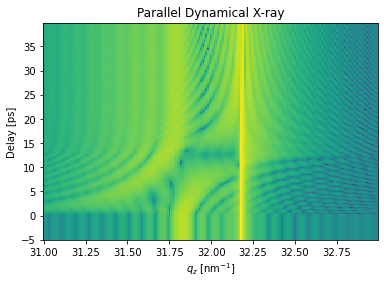

In [22]:
plt.figure()
plt.pcolormesh(dyn.qz[0, :].to('1/nm').magnitude, delays.to('ps').magnitude,
               np.log10(R_par[:, 0, :]), shading='auto')
plt.title('Parallel Dynamical X-ray')
plt.ylabel('Delay [ps]')
plt.xlabel('$q_z$ [nm$^{-1}$]')
plt.show()